<a href="https://colab.research.google.com/github/ariakhademi/timeseries/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series forecasting analysis for the S&P 500 dataset from Kaggle: https://www.kaggle.com/datasets/camnugent/sandp500

I chose to forecast closing price of Apple, denoted by APPL. This analysis predicts the trend of the closing price of APPL and evaluates with test data.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

In [218]:
df = pd.read_csv('all_stocks_5yr.csv')
names = df['Name'].unique()
print(f'Names of all companies: {names}')

Names of all companies: ['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'ADS' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV' 'AIZ' 'AJG'
 'AKAM' 'ALB' 'ALGN' 'ALK' 'ALLE' 'ALL' 'ALXN' 'AMAT' 'AMD' 'AME' 'AMGN'
 'AMG' 'AMP' 'AMT' 'AMZN' 'ANDV' 'ANSS' 'ANTM' 'AON' 'AOS' 'APA' 'APC'
 'APD' 'APH' 'APTV' 'ARE' 'ARNC' 'ATVI' 'AVB' 'AVGO' 'AVY' 'AWK' 'AXP'
 'AYI' 'AZO' 'A' 'BAC' 'BAX' 'BA' 'BBT' 'BBY' 'BDX' 'BEN' 'BF.B' 'BHF'
 'BHGE' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BRK.B' 'BSX' 'BWA' 'BXP' 'CAG'
 'CAH' 'CAT' 'CA' 'CBG' 'CBOE' 'CBS' 'CB' 'CCI' 'CCL' 'CDNS' 'CELG' 'CERN'
 'CFG' 'CF' 'CHD' 'CHK' 'CHRW' 'CHTR' 'CINF' 'CI' 'CLX' 'CL' 'CMA' 'CMCSA'
 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COL' 'COO' 'COP' 'COST'
 'COTY' 'CPB' 'CRM' 'CSCO' 'CSRA' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS'
 'CVX' 'CXO' 'C' 'DAL' 'DE' 'DFS' 'DGX' 'DG' 'DHI' 'DHR' 'DISCA' 'DISCK'
 'DISH' 'DIS' 'DLR' 'DLTR' 'DOV' 'DPS' 'DRE' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN'
 'DWDP' 'DXC' 'D' 'EA' 'EBAY' '

In [219]:
# choose APPLE
aapl = df[df['Name'] == 'AAPL']
aapl['date'] = pd.to_datetime(aapl['date'])
aapl.set_index('date', inplace=True)
closing_price = aapl['close'].dropna()

# adf test to determine stationarity
adf_test = adfuller(closing_price)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= 0.05:
    print("The time series is stationary.")
else:
  while(adf_test[1] > 0.05):
    print("The time series is non-stationary. Will perform differencing.")
    diff_closing_price = closing_price.diff().dropna()
    print('after differencing:\n')
    # adf test to determine stationarity
    adf_test = adfuller(diff_closing_price)
    print('ADF Statistic:', adf_test[0])
    if (adf_test[1] < 0.05):
      print('p-value:', adf_test[1])
      print("The time series became stationary after differencing because p-value is < 0.05")
      break

ADF Statistic: -0.6650906914089914
p-value: 0.8555858445838954
The time series is non-stationary. Will perform differencing.
after differencing:

ADF Statistic: -34.82009125088739
p-value: 0.0
The time series became stationary after differencing because p-value is < 0.05


<ipython-input-219-121751febfec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['date'] = pd.to_datetime(aapl['date'])


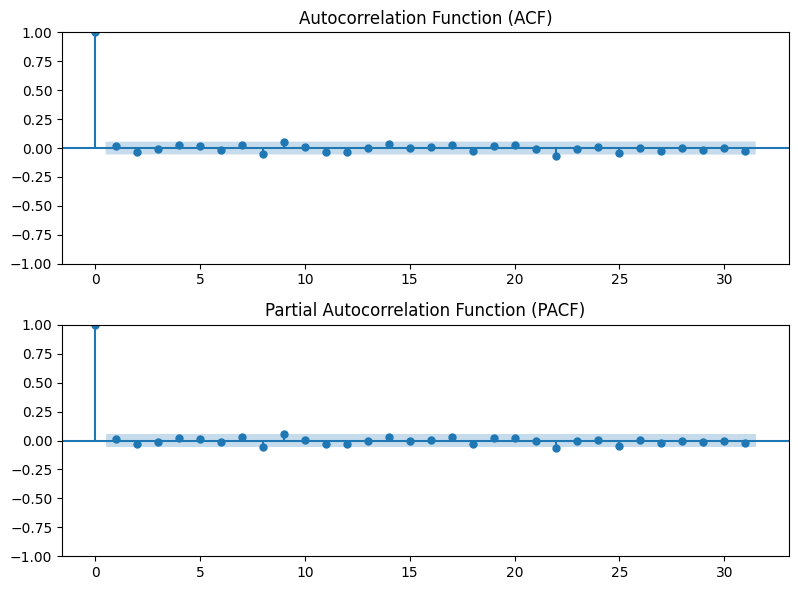

In [220]:
# analyze the ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(diff_closing_price, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(diff_closing_price, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

Plots above show a significant drop at lag 1, so we'll take p=q=1 for the ARIMA model.

In [221]:
# train/test split: 80% for training
train_size = int(len(diff_closing_price) * 0.8)
train, test = diff_closing_price[:train_size], diff_closing_price[train_size:]

In [222]:
# fit an ARIMA model
model = ARIMA(train, order=(1, 0, 1))
arima_model = model.fit()
print(arima_model.summary())
# predict
predictions = arima_model.forecast(steps=len(test))
predictions = round(predictions, 2)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1006
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1827.572
Date:                Wed, 29 Jan 2025   AIC                           3663.145
Time:                        23:45:04   BIC                           3682.800
Sample:                             0   HQIC                          3670.613
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0634      0.048      1.332      0.183      -0.030       0.157
ar.L1         -0.8259      0.226     -3.661      0.000      -1.268      -0.384
ma.L1          0.8455      0.216      3.922      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [224]:
# evalue with RMSE
rmse = sqrt(mean_squared_error(test.values, predictions.values))
print('AAPL test RMSE: %.3f' % rmse)

AAPL test RMSE: 1.876


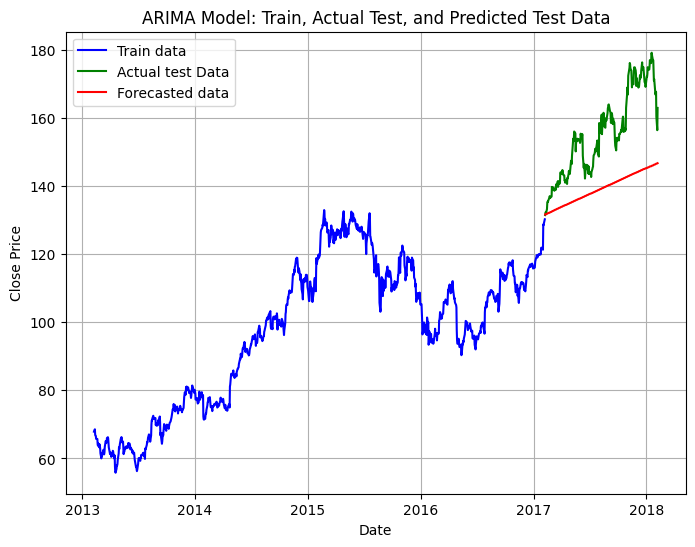

In [225]:
# reverting to original data because we did differencing once
last_closing_price = closing_price.iloc[train_size]
reverted_forecasts = np.cumsum(predictions) + last_closing_price
actual_test = closing_price.iloc[train_size:train_size + len(test)]

plt.figure(figsize=(8, 6))
plt.plot(closing_price.index[:train_size], closing_price[:train_size], label='Train data', color='blue')
plt.plot(actual_test.index, actual_test, label='Actual test Data', color='green')
plt.plot(actual_test.index, reverted_forecasts, label='Forecasted data', color='red')
plt.title('ARIMA Model: Train, Actual Test, and Predicted Test Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()